In [24]:
# helper function for importing

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])
        __import__(package)

In [25]:
import numpy as np
import pip
from core.models import LogisticRegression
from core.optimizers import *
from core.regularizers import *
from sklearn.metrics import classification_report
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
import requests
import idx2numpy
import gzip
import shutil

packages = ['gzip', 'shutil', 'idx2numpy', 'requests']

for package in packages:
    import_or_install(package)

In [26]:
def load_data():
    
    train_images = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
    train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
    test_images = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
    test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
    
    urls = [train_images, train_labels, test_images, test_labels]
    
    responses = [requests.get(url, allow_redirects=True) for url in urls]
    
    names = ['train_images', 'train_labels', 'test_images', 'test_labels']
    
    for index, res in enumerate(responses):
        open(f'./datasets/prime_numbers/{names[index]}-gz', 'wb').write(res.content)
        
    for name in names:
        with gzip.open(f'./datasets/prime_numbers/{name}-gz', 'rb') as f_in:
            with open(f'./datasets/prime_numbers/{name}', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    
    # remove files
    for name in names:
        os.remove(f'./datasets/prime_numbers/{name}-gz')

    f_read = open('./datasets/prime_numbers/train-images','rb')
    X_train = idx2numpy.convert_from_file(f_read)

    f_read = open('./datasets/prime_numbers/train-labels', 'rb')
    y_train = idx2numpy.convert_from_file(f_read)

    f_read = open('./datasets/prime_numbers/test-images', 'rb')
    X_test = idx2numpy.convert_from_file(f_read)
    
    f_read = open('./datasets/prime_numbers/test-labels', 'rb')
    y_test = idx2numpy.convert_from_file(f_read)

    X_train = X_train.reshape(len(X_train), 784)

    X_test = X_test.reshape(len(X_test), 784)


    tmp_X = []
    tmp_y = []

    for index,label in enumerate(y_train):
        if label in [2,3,5,7]:
            tmp_X.append(X_train[index])
            tmp_y.append(1)
        elif label in [4,6,8,9]:
            tmp_X.append(X_train[index])
            tmp_y.append(0)

    tmp_X_test = []
    tmp_y_test = []

    for index,label in enumerate(y_test):
        if label in [2,3,5,7]:
            tmp_X_test.append(X_test[index])
            tmp_y_test.append(1)
        elif label in [4,6,8,9]:
            tmp_X_test.append(X_test[index])
            tmp_y_test.append(0)



    X_train = np.array(tmp_X)
    X_test = np.array(tmp_X_test)
    y_train = np.array(tmp_y)
    y_test = np.array(tmp_y_test)
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = load_data()

In [28]:
print("Num of our training samples: \t", X_train.shape[0])
print("Num of our testing samples: \t", X_test.shape[0])

Num of our training samples: 	 47335
Num of our testing samples: 	 7885


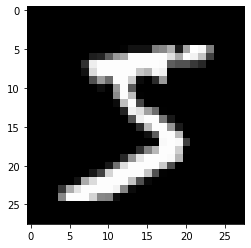

In [29]:
# single record
number = np.reshape(X_train[0], (28,28))
plt.imshow(number, cmap='gray')
plt.show()

In [30]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

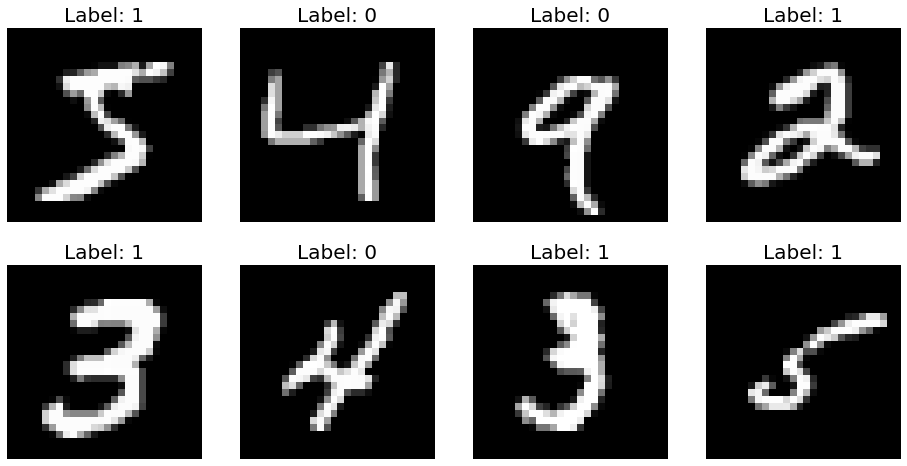

In [31]:
plt.figure(figsize=(16,8))

for i, (X, label) in enumerate(zip(X_train[0:8], y_train[0:8])):
    plt.subplot(2, 4, i + 1)
    plt.title(f'Label: {label}', fontsize = 20)
    plt.axis('off')
    plt.imshow(np.reshape(X, (28,28)), cmap='gray')
plt.show()

In [32]:
num_of_samples = 10000

X_train_ = X_train[:num_of_samples]
y_train_ = y_train[:num_of_samples]

In [33]:
optimizers = []

optimizers.append(GradientDescentOptimizer())
optimizers.append(MomentumGradientDescentOptimizer())
optimizers.append(AdaGradOptimizer())
optimizers.append(RMSPropOptimizer())
optimizers.append(AdamOptimizer())

In [34]:
for optimizer in optimizers:
    model = LogisticRegression(optimizer = optimizer)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("="*len(str(optimizer)))
    print(optimizer)
    print("="*len(str(optimizer)))
    print(classification_report(y_test, y_pred))

name: GradientDescentOptimizer, learning_rate: 0.03
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3923
           1       0.91      0.91      0.91      3962

    accuracy                           0.91      7885
   macro avg       0.91      0.91      0.91      7885
weighted avg       0.91      0.91      0.91      7885

name: MomentumGradientDescentOptimizer, learning_rate: 0.03, momentum_rate: 0.9
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3923
           1       0.93      0.87      0.90      3962

    accuracy                           0.90      7885
   macro avg       0.90      0.90      0.90      7885
weighted avg       0.90      0.90      0.90      7885



KeyboardInterrupt: 

In [ ]:
model = LogisticRegression(optimizer = RMSPropOptimizer())
result = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', error_score='raise')

In [ ]:
print(result)